In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import dask
import dask.array as da
import dask.dataframe as dd

C:\Users\19252\.conda\envs\research\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [ ]:
%%time
import polars as pl
train_series = (pl.scan_parquet("data/train_series.parquet")
                .with_columns(
                    (
#                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

In [3]:
%%time 
all_training_data = pd.read_parquet("data/train_series.parquet")

CPU times: total: 46.6 s
Wall time: 30.7 s


In [12]:
%%time 
import polars as pl
all_train_events = (pl.scan_csv('data/train_events.csv')
                .with_columns(
                    (
#                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
#                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
#                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
#                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
#                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: total: 0 ns
Wall time: 134 ms


In [6]:
%%time 
data_series = {}
for series in ["5f94bb3e1bed","038441c925bb"]:
    data_series[series] = all_training_data[all_training_data["series_id"] == series]

CPU times: total: 10.3 s
Wall time: 10.5 s


In [9]:
example_time_series_WO_NaN = data_series["5f94bb3e1bed"]
example_time_series_W_NaN = data_series["038441c925bb"]
example_time_series_W_NaN.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [14]:
%%time 
data_events = {}
for series in ["5f94bb3e1bed","038441c925bb"]:
    data_events[series] = all_train_events[all_train_events["series_id"] == series]

CPU times: total: 0 ns
Wall time: 15.5 ms


In [20]:
example_time_event_WO_NaN = data_events["5f94bb3e1bed"]
example_time_event_W_NaN = data_events["038441c925bb"]

#df_copy = example_time_event_WO_NaN.copy()
example_time_event_WO_NaN["awake"] = example_time_event_WO_NaN["event"].replace({"onset":1,"wakeup":0})
#df_copy = example_time_event_W_NaN.copy()
example_time_event_W_NaN["awake"] = example_time_event_W_NaN["event"].replace({"onset":1,"wakeup":0})

C:\Users\19252\AppData\Local\Temp\ipykernel_28844\1432589560.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_time_event_WO_NaN["awake"] = example_time_event_WO_NaN["event"].replace({"onset":1,"wakeup":0})
C:\Users\19252\AppData\Local\Temp\ipykernel_28844\1432589560.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_time_event_W_NaN["awake"] = example_time_event_W_NaN["event"].replace({"onset":1,"wakeup":0})


In [22]:
example_time_merge_WO_NaN = pd.merge(example_time_series_WO_NaN, example_time_event_WO_NaN[['step','awake']], on='step', how='left')
example_time_merge_WO_NaN["awake"] = example_time_merge_WO_NaN["awake"].bfill(axis ='rows')
# final section:
# train_events.groupby('series_id').tail(1)["event"].unique()
# Result: the last event is always a "wakeup"
example_time_merge_WO_NaN['awake'] = example_time_merge_WO_NaN['awake'].fillna(1) # awake
example_time_merge_WO_NaN["awake"] = example_time_merge_WO_NaN["awake"].astype("int")
#example_time_merge_W_NaN = data_events["038441c925bb"]

In [23]:
example_time_merge_W_NaN = pd.merge(example_time_series_W_NaN, example_time_event_W_NaN[['step','awake']], on='step', how='left')
example_time_merge_W_NaN["awake"] = example_time_merge_W_NaN["awake"].bfill(axis ='rows')
# final section:
# train_events.groupby('series_id').tail(1)["event"].unique()
# Result: the last event is always a "wakeup"
example_time_merge_W_NaN['awake'] = example_time_merge_W_NaN['awake'].fillna(1) # awake
example_time_merge_W_NaN["awake"] = example_time_merge_W_NaN["awake"].astype("int")
#example_time_merge_W_NaN = data_events["038441c925bb"]

In [31]:
example_time_merge_W_NaN.head()

,series_id,step,timestamp,anglez,enmo,awake,median_value_anglez_25
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217,1,None
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215,1,None
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216,1,None
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213,1,None
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215,1,None


### anglez for series 5f94bb3e1bed

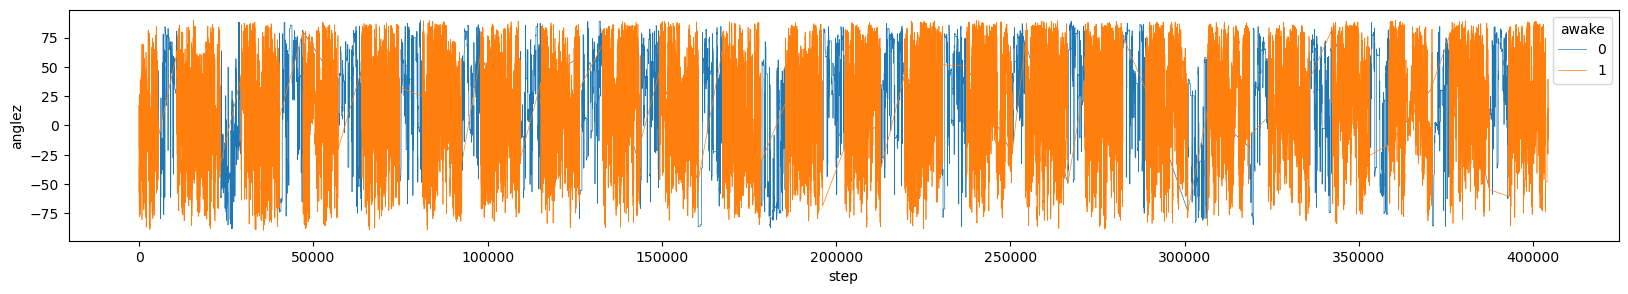

In [25]:
# Specific steps with missing values
from IPython.display import Markdown

# Display Markdown
display(Markdown('### anglez for series ' + "5f94bb3e1bed"))

# Create the plot
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=example_time_merge_WO_NaN, x="step", y="anglez", hue="awake", linewidth=0.5)

plt.show()

In [32]:
#import pandas as pd

def add_median_column(df, window_radius, feature, fill_value=None, timestep_column = "step"):
    # Create an empty column for the median values
    df[f'median_value_{feature}_{window_radius}'] = fill_value
    
    # Iterate through each row in the dataframe
    for i in range(len(df)):
        # Get the current timestep
        current_step = i
        
        # Define the time window around the current timestep
        start_step = current_step - window_radius
        end_step = current_step + window_radius
        
        # Extract the values within the time window
        window_values = df.loc[(df[timestep_column] >= start_step) & (df[timestep_column] <= end_step), feature]
        
        # Check if there are enough values to calculate the median
        #if len(window_values) >= window_size:
        # Calculate and set the median value in the new column
        df.at[i, f'median_value_{feature}_{window_radius}'] = window_values.median()
    
    return df


In [53]:
#import pandas as pd

def add_variance_column(df, window_radius, feature, fill_value=None, timestep_column = "step"):
    # Create an empty column for the median values
    df[f'var_value_{feature}_{window_radius}'] = fill_value
    
    # Iterate through each row in the dataframe
    for i in range(len(df)):
        # Get the current timestep
        current_step = i
        
        # Define the time window around the current timestep
        start_step = current_step - window_radius
        end_step = current_step + window_radius
        
        # Extract the values within the time window
        window_values = df.loc[(df[timestep_column] >= start_step) & (df[timestep_column] <= end_step), feature]
        
        # Check if there are enough values to calculate the median
        #if len(window_values) >= window_size:
        # Calculate and set the median value in the new column
        df.at[i, f'var_value_{feature}_{window_radius}'] = window_values.var()
    
    return df

In [58]:
#import pandas as pd

def add_inc_column(df, dif_over_step, feature, fill_value=None, timestep_column = "step"):
    # Create an empty column for the median values
    df[f'inc_value_{feature}_over_{dif_over_step}_steps'] = fill_value
    
    # Iterate through each row in the dataframe
    for i in range(len(df)-dif_over_step):

        #if len(window_values) >= window_size:
        # Calculate and set the median value in the new column
        df.at[i, f'inc_value_{feature}_over_{dif_over_step}_steps'] = abs(df.at[i, feature] - df.at[i+dif_over_step, feature])
    for i in range((len(df)-dif_over_step+1),len(df)):
        df.at[i, f'inc_value_{feature}_over_{dif_over_step}_steps'] = df.at[len(df)-dif_over_step, f'inc_value_{feature}_over_{dif_over_step}_steps']
    
    return df

In [44]:
example_time_merge_W_NaN = add_median_column(df = example_time_merge_W_NaN, window_radius=25, feature="anglez", fill_value=None, timestep_column = "step")
example_time_merge_WO_NaN = add_median_column(df = example_time_merge_WO_NaN, window_radius=25, feature="anglez", fill_value=None, timestep_column = "step")
example_time_merge_W_NaN = add_median_column(df = example_time_merge_W_NaN, window_radius=25, feature="enmo", fill_value=None, timestep_column = "step")
example_time_merge_WO_NaN = add_median_column(df = example_time_merge_WO_NaN, window_radius=25, feature="enmo", fill_value=None, timestep_column = "step")

### anglez for series 038441c925bb

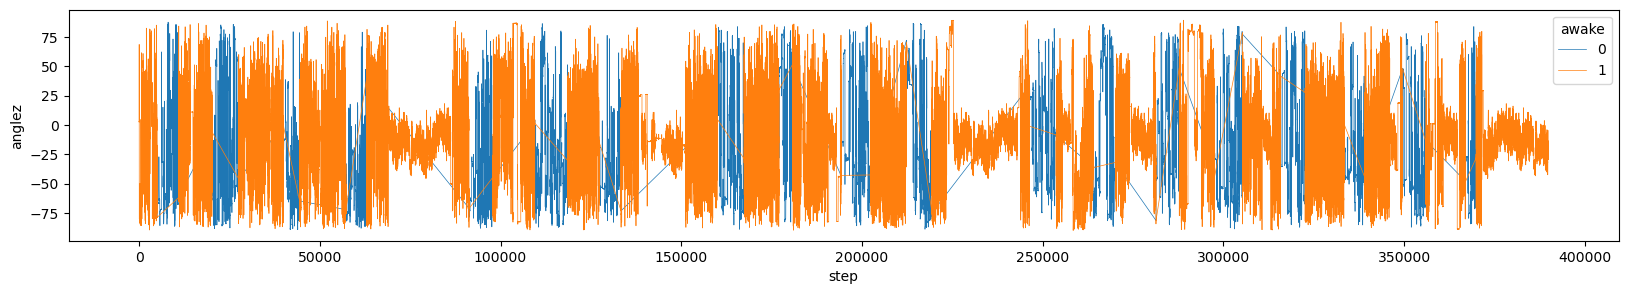

### enmo for series 038441c925bb

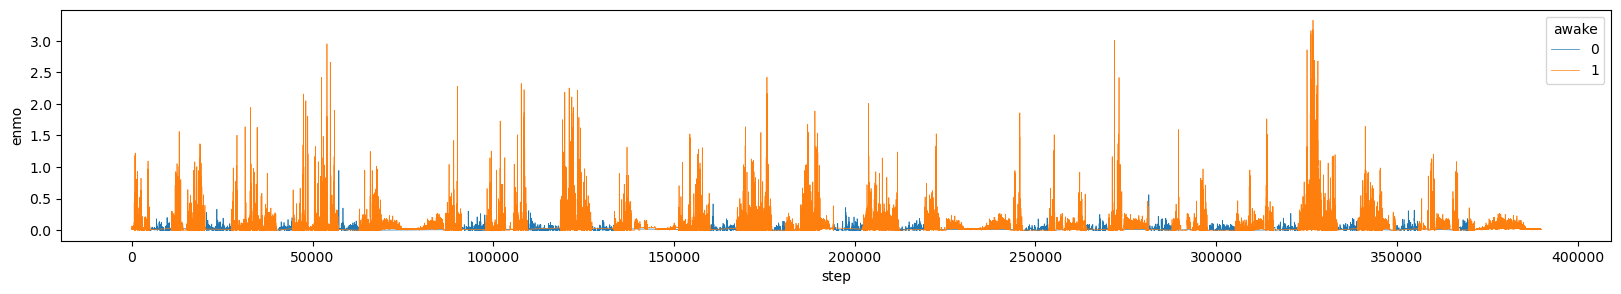

### median_value_anglez_25 for series 038441c925bb

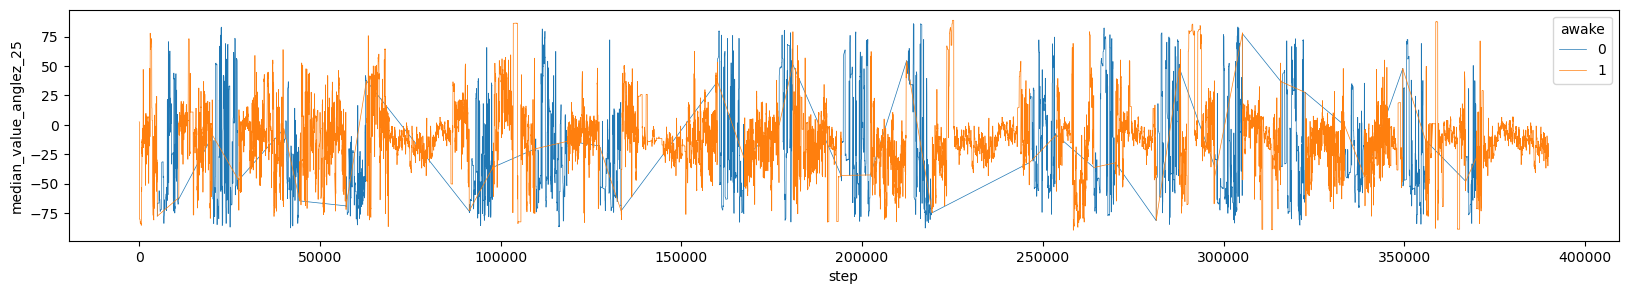

### median_value_enmo_25 for series 038441c925bb

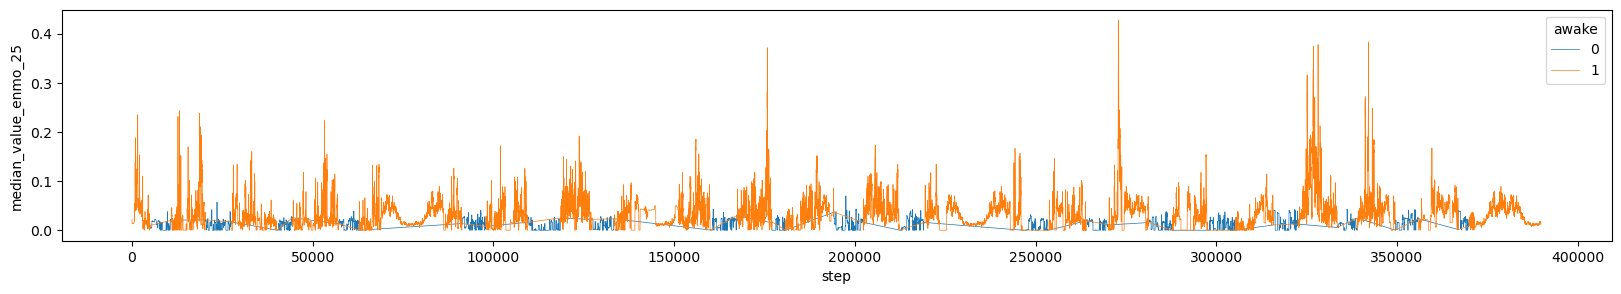

### anglez for series 5f94bb3e1bed

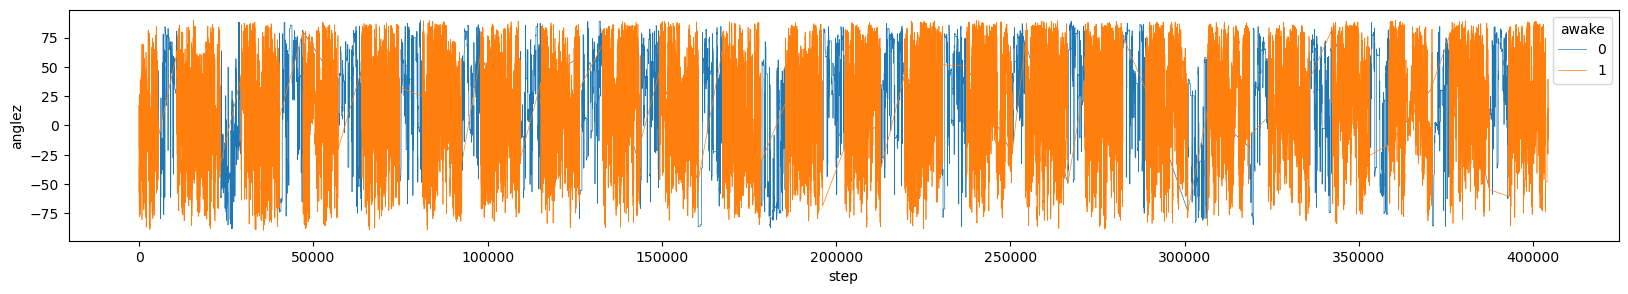

### enmo for series 5f94bb3e1bed

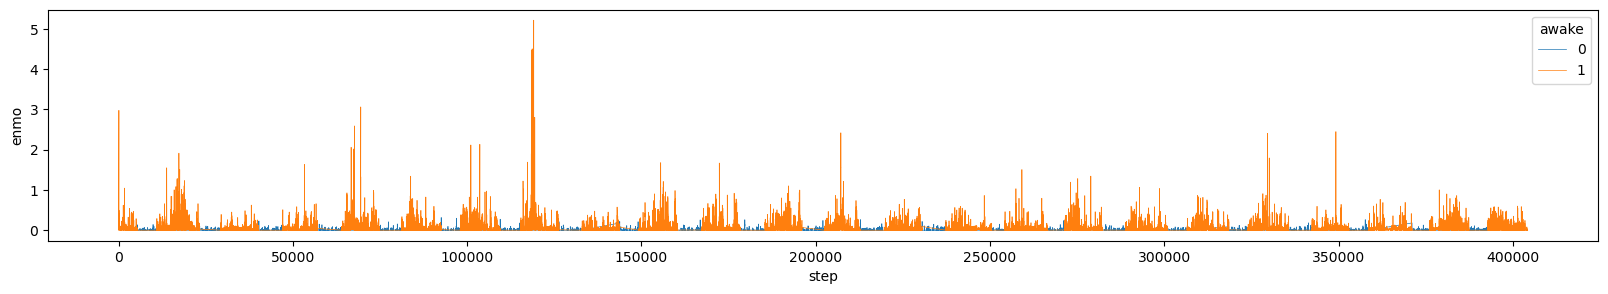

### median_value_anglez_25 for series 5f94bb3e1bed

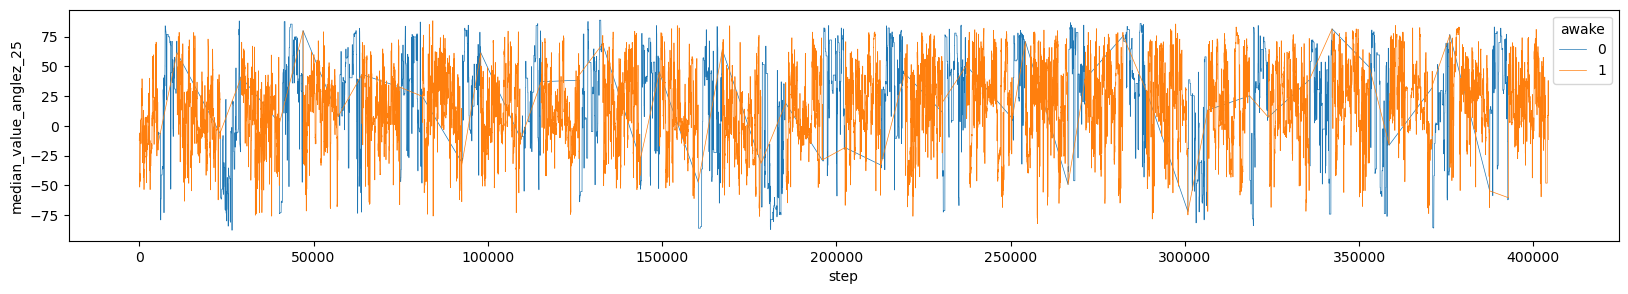

### median_value_enmo_25 for series 5f94bb3e1bed

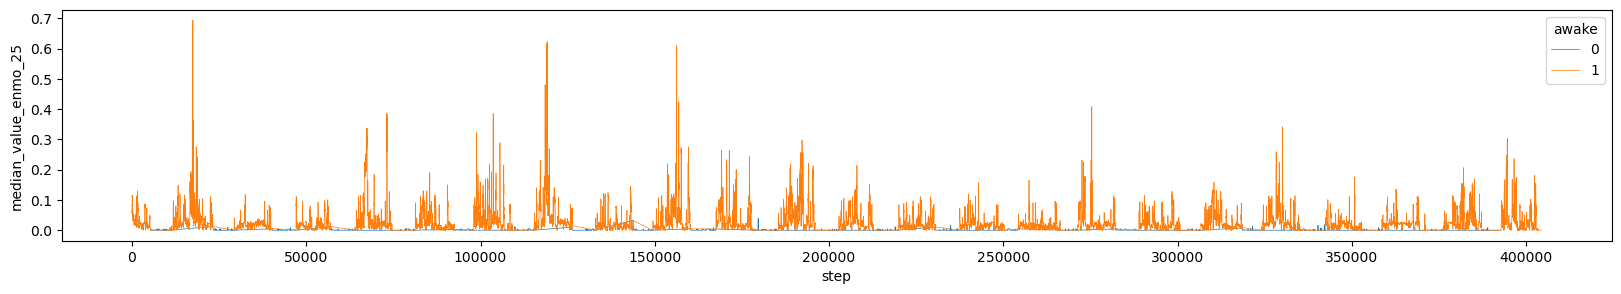

In [52]:
#example_merge_series = [example_time_merge_W_NaN,example_time_merge_WO_NaN]
variable_to_plot = ["anglez","enmo","median_value_anglez_25","median_value_enmo_25"]

for variable in variable_to_plot:

    display(Markdown(f'### {variable} for series ' + "038441c925bb"))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=example_time_merge_W_NaN, x="step", y=variable, hue="awake", linewidth=0.5)
    
    plt.show()
    
for variable in variable_to_plot:

    display(Markdown(f'### {variable} for series ' + "5f94bb3e1bed"))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=example_time_merge_WO_NaN, x="step", y=variable, hue="awake", linewidth=0.5)
    
    plt.show()

In [51]:
example_time_merge_W_NaN = add_median_column(df = example_time_merge_W_NaN, window_radius=25, feature="anglez", fill_value=None, timestep_column = "step")

In [54]:
example_time_merge_W_NaN = add_variance_column(df = example_time_merge_W_NaN, window_radius=25, feature="anglez", fill_value=None, timestep_column = "step")
example_time_merge_WO_NaN = add_variance_column(df = example_time_merge_WO_NaN, window_radius=25, feature="anglez", fill_value=None, timestep_column = "step")
example_time_merge_W_NaN = add_variance_column(df = example_time_merge_W_NaN, window_radius=25, feature="enmo", fill_value=None, timestep_column = "step")
example_time_merge_WO_NaN = add_variance_column(df = example_time_merge_WO_NaN, window_radius=25, feature="enmo", fill_value=None, timestep_column = "step")

### anglez for series 038441c925bb

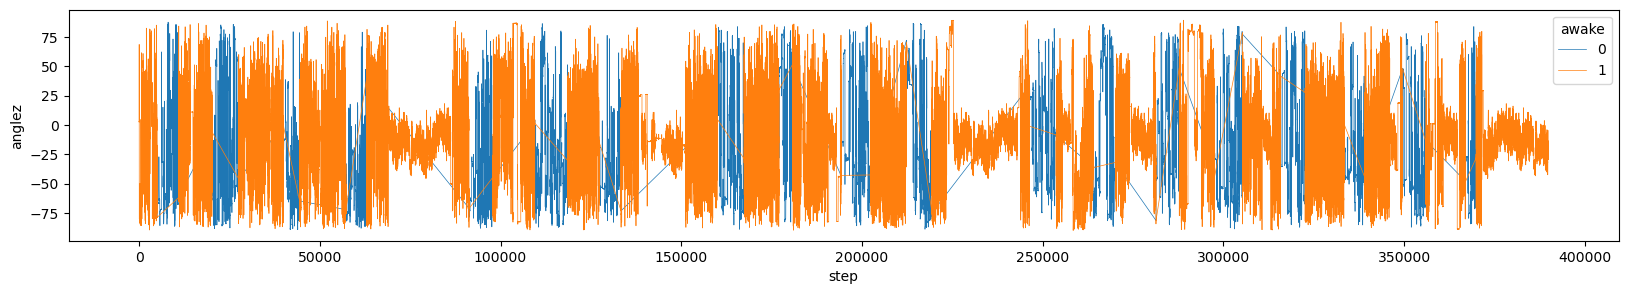

### enmo for series 038441c925bb

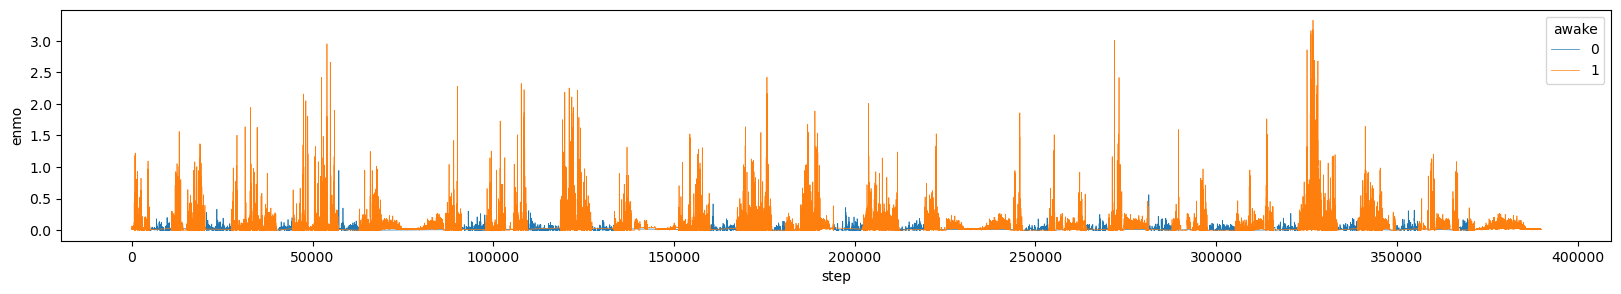

### median_value_anglez_25 for series 038441c925bb

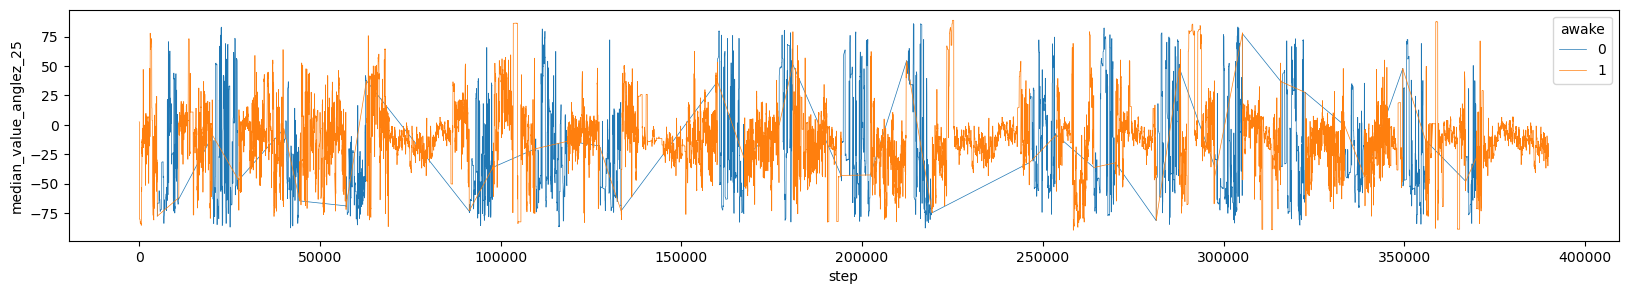

### median_value_enmo_25 for series 038441c925bb

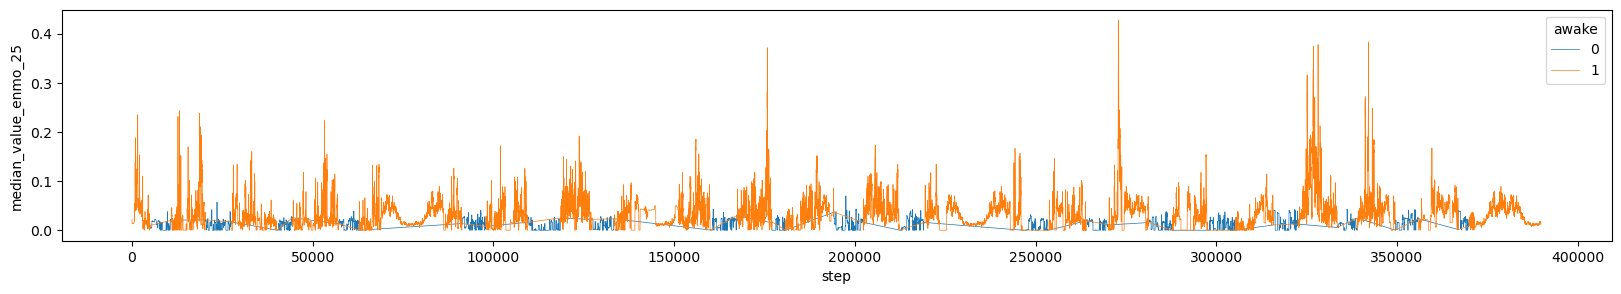

### var_value_anglez_25 for series 038441c925bb

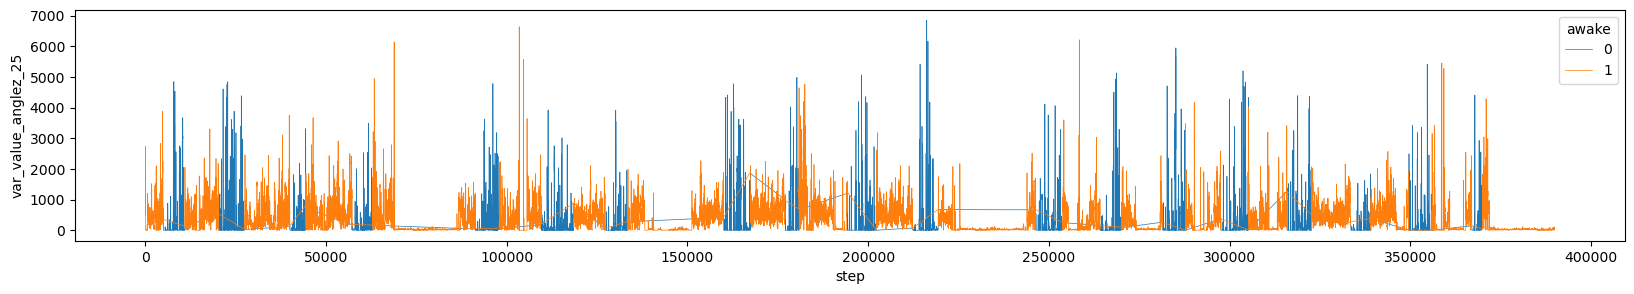

### var_value_enmo_25 for series 038441c925bb

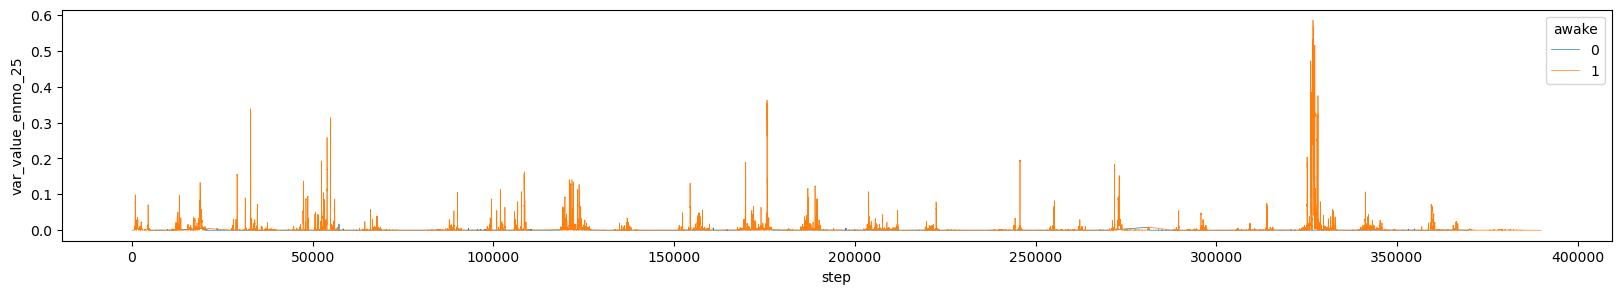

### anglez for series 5f94bb3e1bed

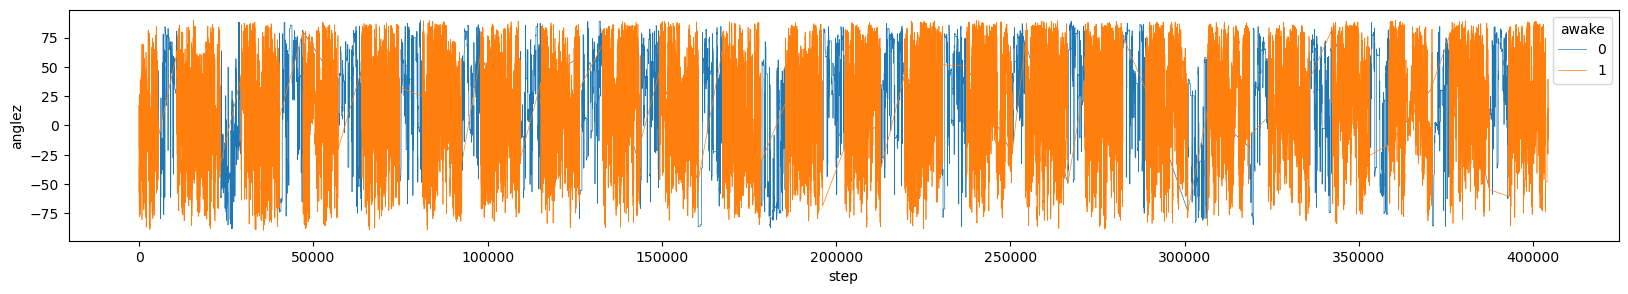

### enmo for series 5f94bb3e1bed

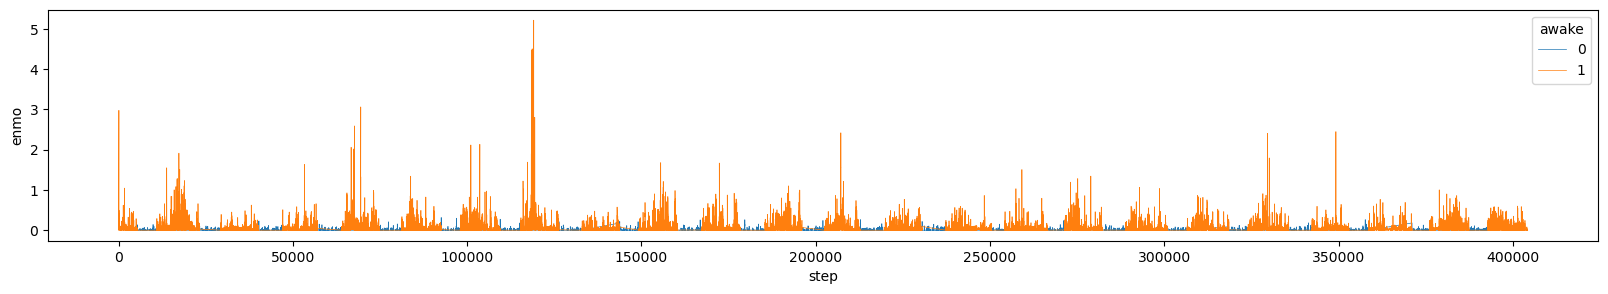

### median_value_anglez_25 for series 5f94bb3e1bed

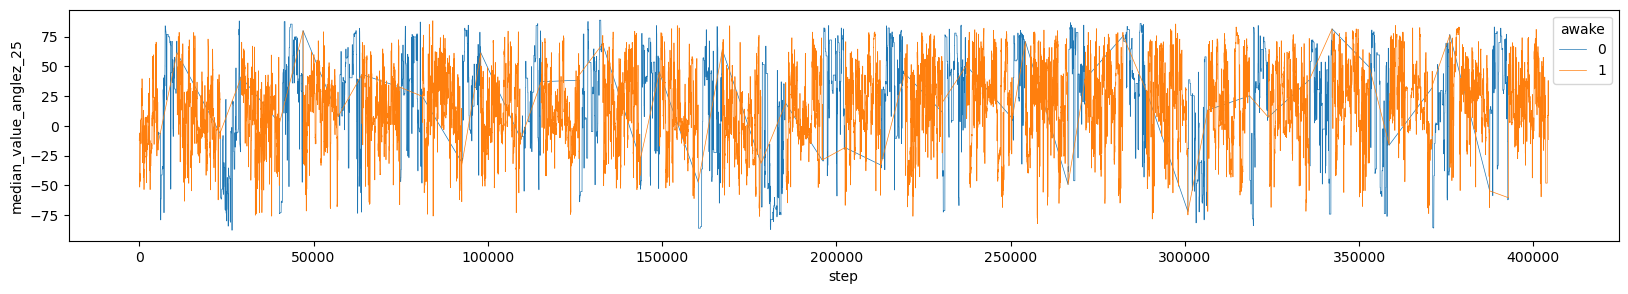

### median_value_enmo_25 for series 5f94bb3e1bed

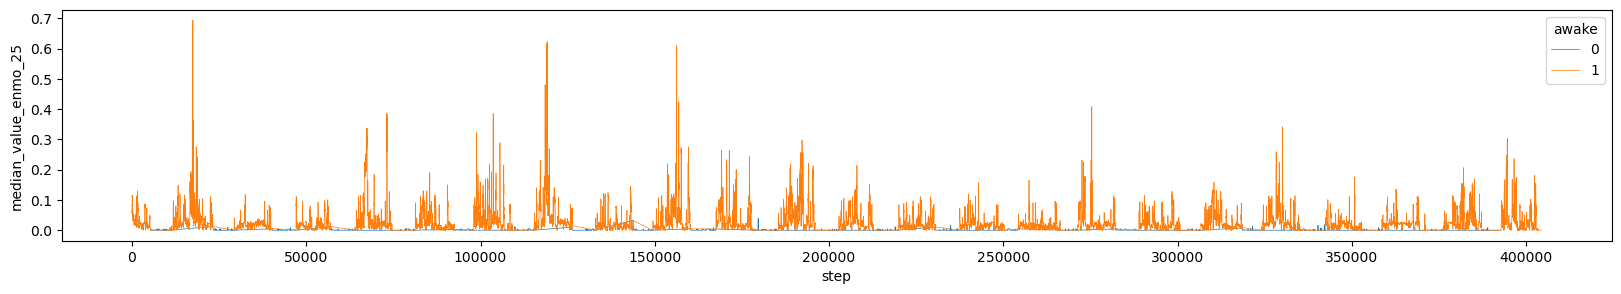

### var_value_anglez_25 for series 5f94bb3e1bed

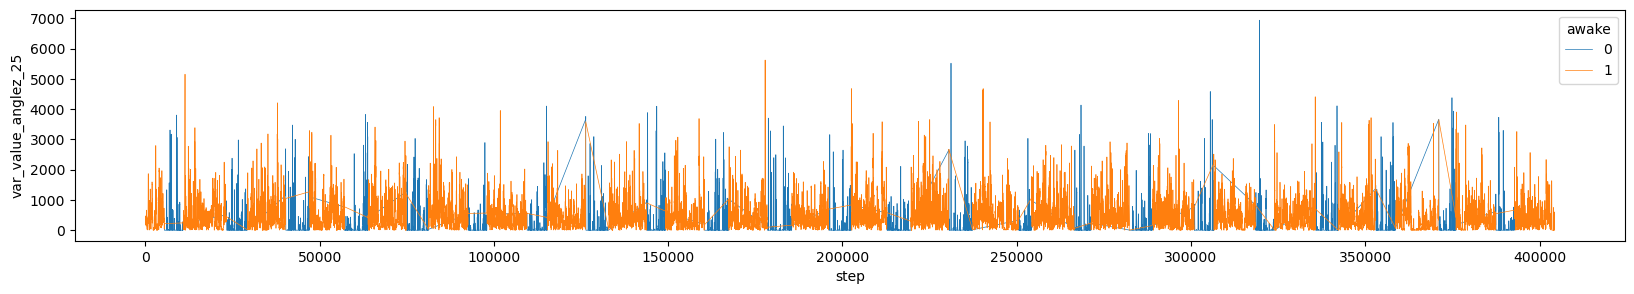

### var_value_enmo_25 for series 5f94bb3e1bed

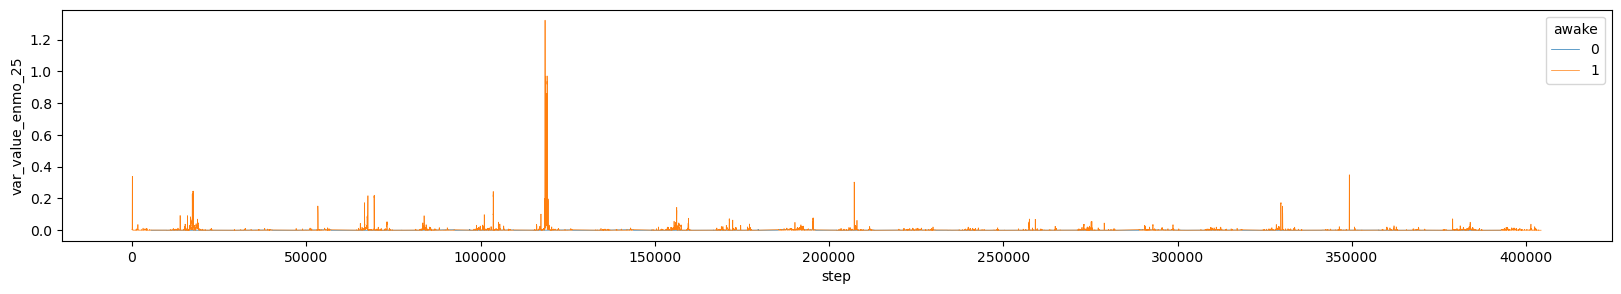

In [55]:
#example_merge_series = [example_time_merge_W_NaN,example_time_merge_WO_NaN]
variable_to_plot = ["anglez","enmo","median_value_anglez_25","median_value_enmo_25","var_value_anglez_25","var_value_enmo_25"]

for variable in variable_to_plot:

    display(Markdown(f'### {variable} for series ' + "038441c925bb"))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=example_time_merge_W_NaN, x="step", y=variable, hue="awake", linewidth=0.5)
    
    plt.show()
    
for variable in variable_to_plot:

    display(Markdown(f'### {variable} for series ' + "5f94bb3e1bed"))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=example_time_merge_WO_NaN, x="step", y=variable, hue="awake", linewidth=0.5)
    
    plt.show()

In [56]:
example_time_merge_W_NaN.head()


,series_id,step,timestamp,anglez,enmo,awake,median_value_anglez_25,median_value_enmo_25,var_value_anglez_25,var_value_enmo_25
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217,1,2.6368,0.02155,515.05603,0.000038
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215,1,2.6368,0.0215,500.724487,0.000039
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216,1,2.6368,0.02155,501.870331,0.000124
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213,1,2.6368,0.0215,801.777954,0.000122
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215,1,2.6368,0.0215,1060.654785,0.00012


### median_value_anglez_25 for series 038441c925bb

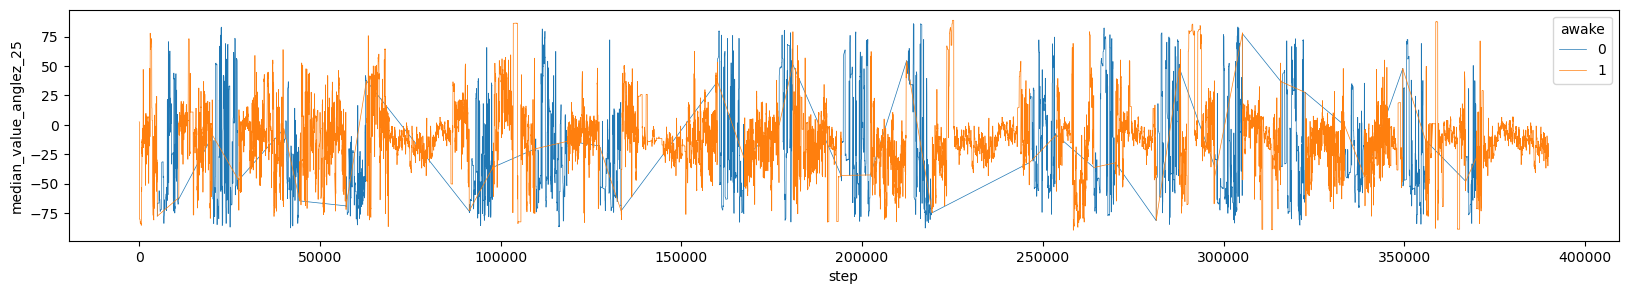

In [37]:
# Display Markdown
display(Markdown('### median_value_anglez_25 for series ' + "038441c925bb"))

# Create the plot
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=example_time_merge_W_NaN, x="step", y="median_value_anglez_25", hue="awake", linewidth=0.5)

plt.show()

### anglez for series 038441c925bb

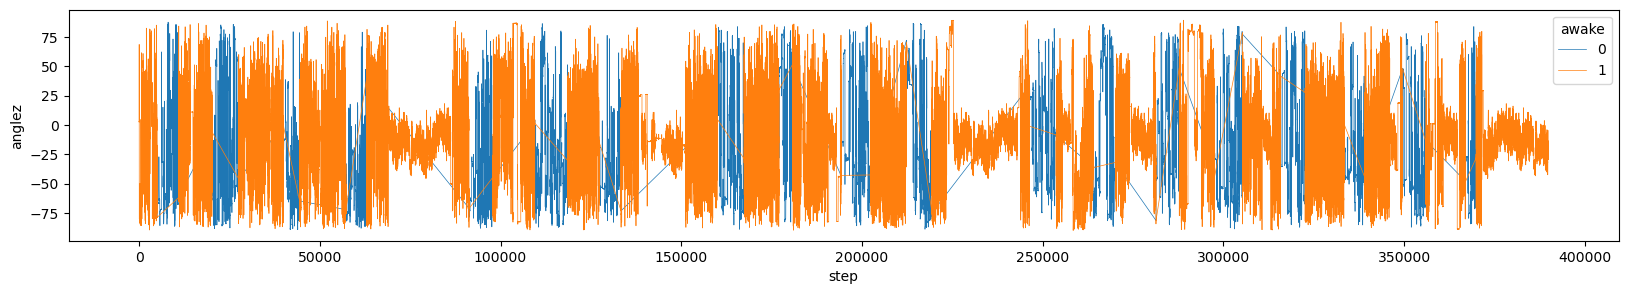

In [38]:
# Display Markdown
display(Markdown('### anglez for series ' + "038441c925bb"))

# Create the plot
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=example_time_merge_W_NaN, x="step", y="anglez", hue="awake", linewidth=0.5)

plt.show()

In [59]:
#add_inc_column(df, dif_over_step, feature, fill_value=None, timestep_column = "step")
example_time_merge_W_NaN = add_inc_column(df = example_time_merge_W_NaN, dif_over_step=1, feature="anglez", fill_value=None, timestep_column = "step")
example_time_merge_WO_NaN = add_inc_column(df = example_time_merge_WO_NaN, dif_over_step=1, feature="anglez", fill_value=None, timestep_column = "step")
example_time_merge_W_NaN = add_inc_column(df = example_time_merge_W_NaN, dif_over_step=1, feature="enmo", fill_value=None, timestep_column = "step")
example_time_merge_WO_NaN = add_inc_column(df = example_time_merge_WO_NaN, dif_over_step=1, feature="enmo", fill_value=None, timestep_column = "step")

In [78]:
example_time_merge_W_NaN.head(6123
                             )


,series_id,step,timestamp,anglez,enmo,awake,median_value_anglez_25,median_value_enmo_25,var_value_anglez_25,var_value_enmo_25,inc_value_anglez_over_1_steps,inc_value_enmo_over_1_steps
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217,1,2.6368,0.02155,515.05603,0.000038,0.0001,0.0002
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215,1,2.6368,0.0215,500.724487,0.000039,0.0002,0.0001
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216,1,2.6368,0.02155,501.870331,0.000124,0.0002,0.0003
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213,1,2.6368,0.0215,801.777954,0.000122,0.0,0.0002
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215,1,2.6368,0.0215,1060.654785,0.00012,0.0001,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...
6118,038441c925bb,6118,2018-08-14T23:59:50-0400,-71.811699,0.0172,0,-71.811699,0.0167,0.006231,0.0,0.053001,0.0
6119,038441c925bb,6119,2018-08-14T23:59:55-0400,-71.758698,0.0172,0,-71.811699,0.0167,0.006268,0.0,0.066505,0.0003
6120,038441c925bb,6120,2018-08-15T00:00:00-0400,-71.825203,0.0169,0,-71.811699,0.0167,0.006195,0.0,0.013504,0.0002
6121,038441c925bb,6121,2018-08-15T00:00:05-0400,-71.811699,0.0167,0,-71.811699,0.0167,0.006387,0.0,0.047195,0.0004


### inc_value_enmo_over_1_steps for series 038441c925bb

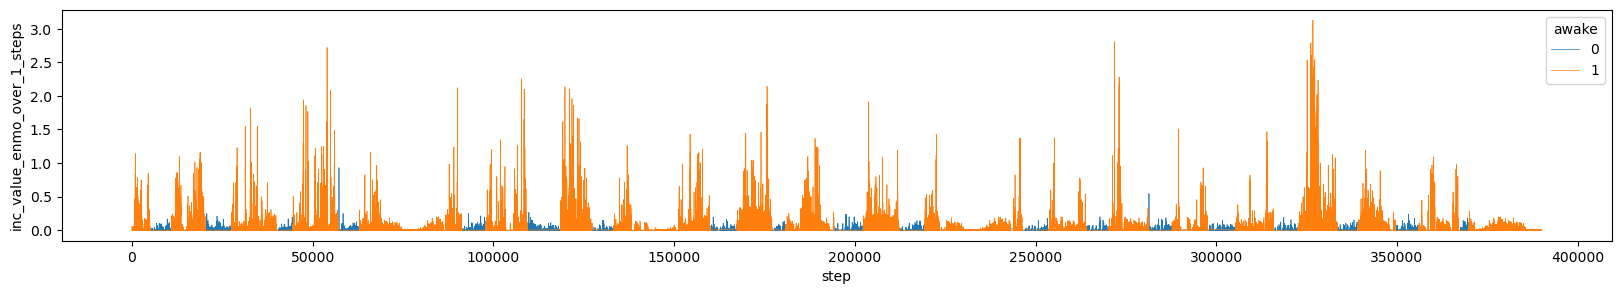

### inc_value_anglez_over_1_steps for series 038441c925bb

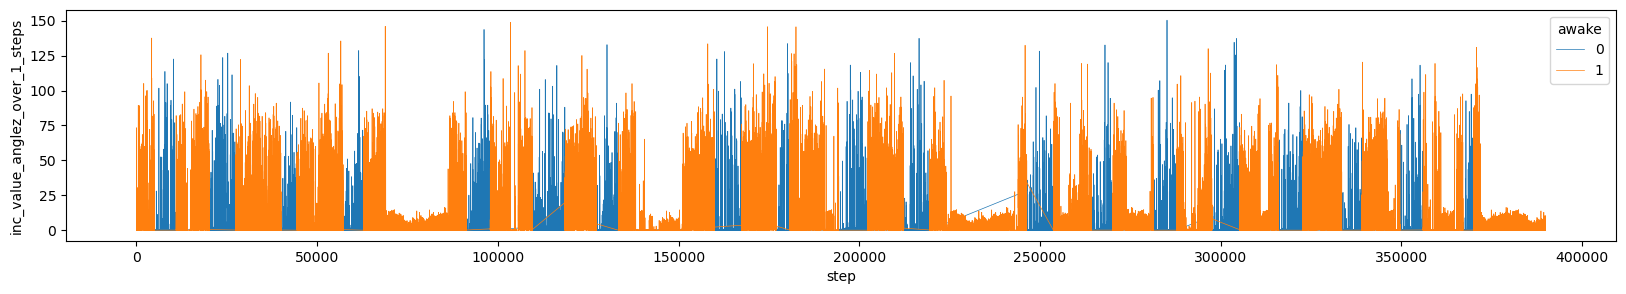

### inc_value_enmo_over_1_steps for series 5f94bb3e1bed

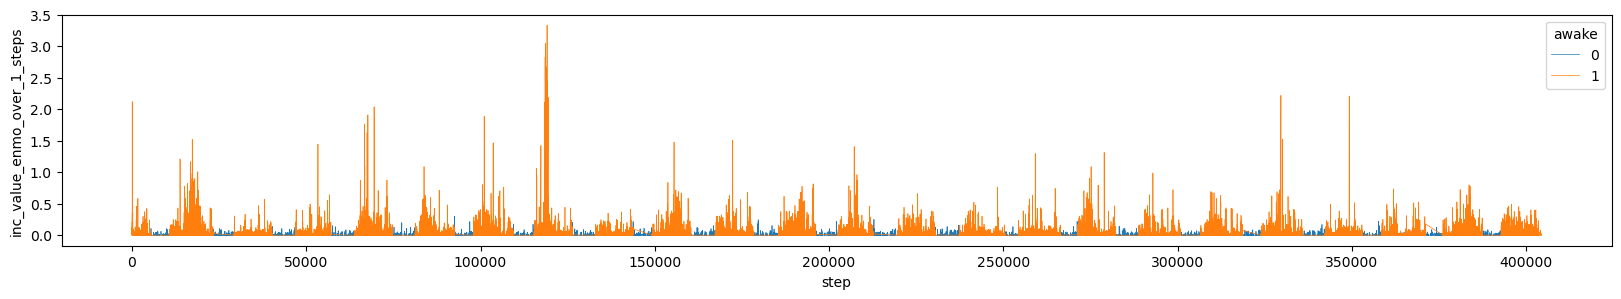

### inc_value_anglez_over_1_steps for series 5f94bb3e1bed

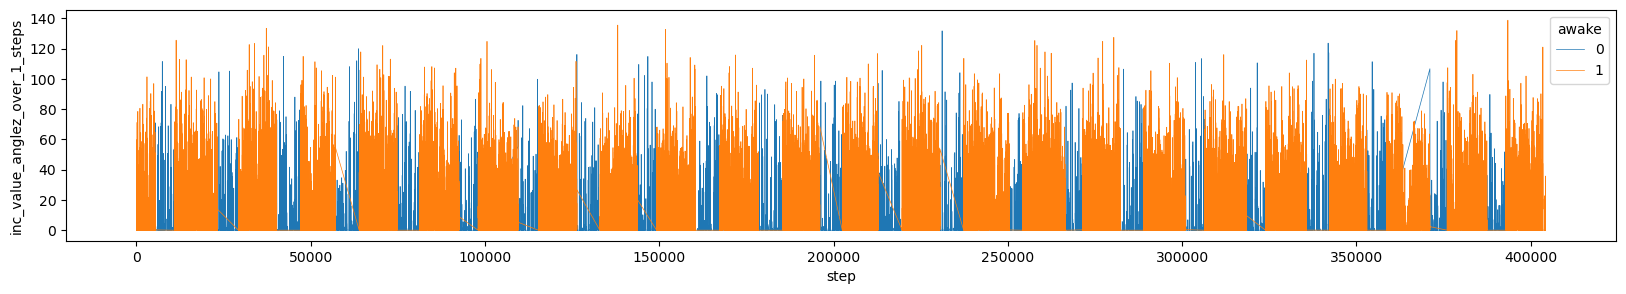

In [61]:
#example_merge_series = [example_time_merge_W_NaN,example_time_merge_WO_NaN]
variable_to_plot = ["inc_value_enmo_over_1_steps","inc_value_anglez_over_1_steps"]

for variable in variable_to_plot:

    display(Markdown(f'### {variable} for series ' + "038441c925bb"))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=example_time_merge_W_NaN, x="step", y=variable, hue="awake", linewidth=0.5)
    
    plt.show()
    
for variable in variable_to_plot:

    display(Markdown(f'### {variable} for series ' + "5f94bb3e1bed"))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=example_time_merge_WO_NaN, x="step", y=variable, hue="awake", linewidth=0.5)
    
    plt.show()